In [1]:
import sys  
sys.path.append('../scripts/')
from robot import *

In [2]:
class PsiCamera(Camera):
    def data(self, cam_pose): 
        orientation_noise = math.pi/90
        
        observed = []
        for lm in self.map.landmarks:
            psi = norm.rvs(loc=math.atan2(cam_pose[1] - lm.pos[1], cam_pose[0] - lm.pos[0]), scale=orientation_noise) #追加
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.oversight(z) 
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append(([z[0], z[1], psi], lm.id))
            
        self.lastdata = observed
        return observed

In [3]:
class LoggerAgent(Agent):  ###logger2agent
    def __init__(self, nu, omega, interval_time, init_pose): 
        super().__init__(nu, omega)
        self.interval_time = interval_time
        self.pose = init_pose
        self.step = 0
        self.log = open("log2.txt", "w") #ファイルの名前は変えておきましょう
        self.log.write("delta {}\n".format(interval_time)) #Δtの記録。追加
        
    def decision(self, observation):
        self.log.write("u {} {} {}\n".format(self.step, self.nu, self.omega)) #追加
        self.log.write("x {} {} {} {}\n".format(self.step, *self.pose))   #観測がなくても記録
        for obs in observation:
            self.log.write("z {} {} {} {} {}\n".format(self.step, obs[1], *obs[0]))
                
        self.step += 1 #インデント注意（decisionが呼ばれると必ずカウント）
        self.log.flush()
        
        self.pose = IdealRobot.state_transition(self.nu, self.omega, self.interval_time, self.pose)
        return self.nu, self.omega

<IPython.core.display.Javascript object>


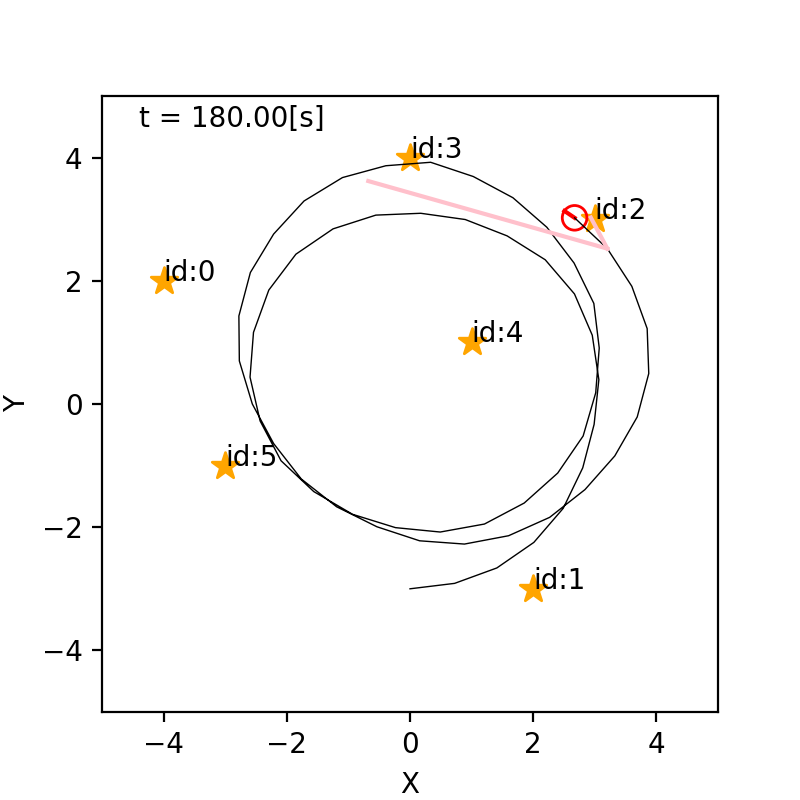

In [4]:
if __name__ == '__main__': 
    time_interval = 3
    world = World(180, time_interval, debug=False) 

    ##真の地図を作成##
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3), (0,4), (1,1), (-3,-1)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m) 

    ## ロボットを作る ##
    init_pose = np.array([0, -3 ,0]).T
    a = LoggerAgent(0.2, 5.0/180*math.pi, time_interval, init_pose)
    r = Robot(init_pose, sensor=PsiCamera(m), agent=a, color="red")
    world.append(r)

    world.draw()